In [1]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt

import datetime as dt
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation,Dropout,Flatten,Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Conv2D

devices = tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(devices[0], 'GPU')

def build_generator():
    noise_shape = (z_dim, )
    activation = Activation("relu")

    model = Sequential(name='generator')

    model.add(Dense(1024, input_shape=noise_shape))
    model.add(activation)
    model.add(BatchNormalization())

    model.add(Dense(7 * 7 * 128))
    model.add(activation)
    model.add(BatchNormalization())

    # 畳み込み層に7 * 7の画像を与える
    model.add(Reshape((7, 7, 128), input_shape=(128 * 7 * 7,)))

    # UpSamplingをし、画像を14 * 14にする
    # 間の要素は０で埋める
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, 5, padding="same"))
    model.add(activation)

    # UpSamplingをし、画像を28 * 28にする
    model.add(UpSampling2D((2, 2)))

    # 畳み込む（ゼロパディングをして、5*5のレイヤーで畳み込み）
    model.add(Conv2D(1, 5, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    return model

def build_discriminator():
    activation = LeakyReLU(alpha=0.2)

    model = Sequential(name='discriminator')

    # 畳み込む（ゼロパディングをし、5*5のフィルタを2マスごとに動かす）
    model.add(Conv2D(64, 5, strides=(2, 2), padding="same", input_shape=(img_shape)))
    model.add(activation)

    # 畳み込み2回目
    model.add(Conv2D(128, 5, strides=(2, 2)))
    model.add(activation)

    # 入力の平坦化（多分１次元化ってこと）
    model.add(Flatten())

    model.add(Dense(256))
    model.add(activation)
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    model.summary()

    return model


def build_combined():
    discriminator.trainable = False
    model = Sequential([generator, discriminator], name='combined')
    model.summary()

    return model

def save_imgs(log_path, epoch):
    # 生成画像を敷き詰めるときの行数、列数
    r, c = 5, 5

    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    # 生成画像を0-1に再スケール
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("{}/{}.png".format(log_path, epoch))
    plt.show()
    plt.close()

def train(epochs, batch_size=512, save_interval=1):
    #mnist
    (X_train, _),(_, _) = mnist.load_data()

    #change -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5)/127.5

    #dim2 -> dim3
    X_train = np.expand_dims(X_train, axis = 3)

    half_batch = int(batch_size / 2)
    num_batches = int(X_train.shape[0] / half_batch)
    print("Number of Batches : ", num_batches)

    log_path = 'log/{}/images'.format(dt.datetime.now().strftime("%Y-%m-%d_%H%M%S"))
    os.makedirs(log_path, exist_ok=True)
    
    for epoch in range(epochs):
        for iteration in range(num_batches):
            #discriminator
                
            #バッチサイズの半分をgeneratorから作成
            noise = np.random.normal(0, 1, (half_batch, z_dim))
            gen_imgs = generator.predict(noise)

            #バッチサイズの半分を教師データからピックアップ
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            #training
            #本物と偽物は別々に
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

            #それぞれの損失関数を平均
            d_loss = np.add(d_loss_real, d_loss_fake) / 2

            #generator
            noise = np.random.normal(0, 1, (batch_size, z_dim))

            #正解に近づけるようにする(本物ラベル、1)
            valid_y = np.array([1] * batch_size)

            #training
            g_loss = combined_model.train_on_batch(noise, valid_y)

        # 指定した間隔で生成画像を保存
        if epoch % save_interval == 0:
            print ("epoch:%d, iter:%d,  [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, iteration, d_loss[0], 100*d_loss[1], g_loss))
            save_imgs(log_path, epoch)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               819456    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)               

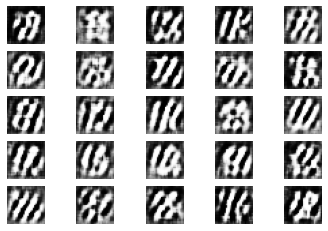

epoch:1, iter:233,  [D loss: 0.702520, acc.: 44.14%] [G loss: 0.696158]


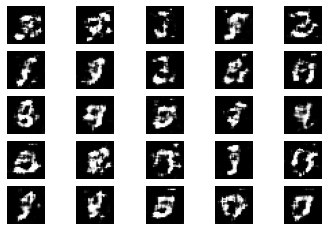

epoch:2, iter:233,  [D loss: 0.702167, acc.: 38.28%] [G loss: 0.706338]


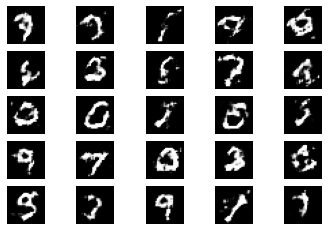

epoch:3, iter:233,  [D loss: 0.697376, acc.: 39.26%] [G loss: 0.699950]


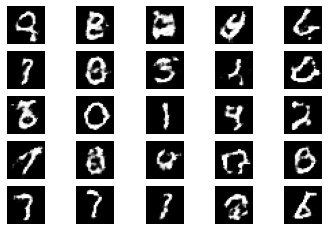

epoch:4, iter:233,  [D loss: 0.698456, acc.: 40.62%] [G loss: 0.697357]


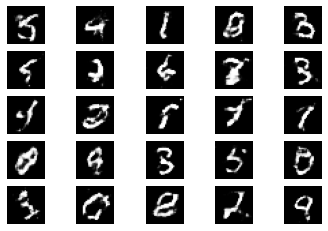

epoch:5, iter:233,  [D loss: 0.696703, acc.: 41.80%] [G loss: 0.698966]


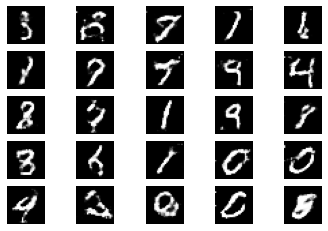

epoch:6, iter:233,  [D loss: 0.695184, acc.: 45.70%] [G loss: 0.698470]


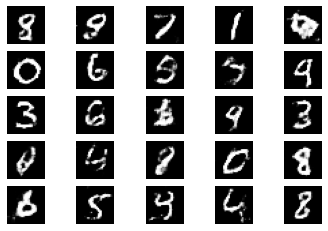

epoch:7, iter:233,  [D loss: 0.695924, acc.: 42.77%] [G loss: 0.704577]


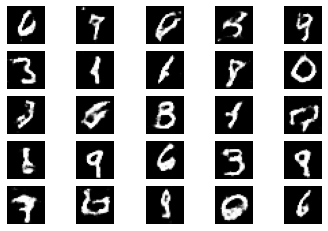

epoch:8, iter:233,  [D loss: 0.698149, acc.: 41.21%] [G loss: 0.693873]


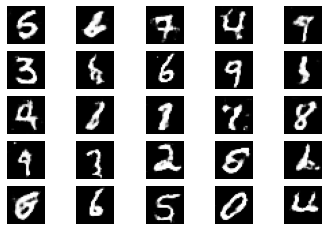

epoch:9, iter:233,  [D loss: 0.693313, acc.: 49.22%] [G loss: 0.698194]


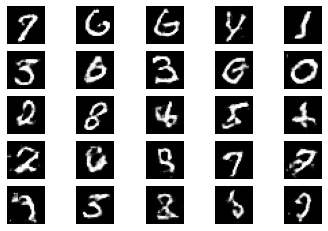

epoch:10, iter:233,  [D loss: 0.696656, acc.: 41.41%] [G loss: 0.697071]


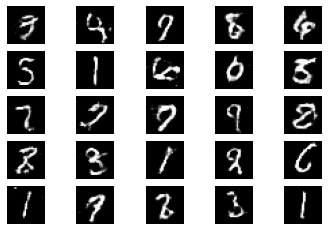

epoch:11, iter:233,  [D loss: 0.694823, acc.: 50.59%] [G loss: 0.701845]


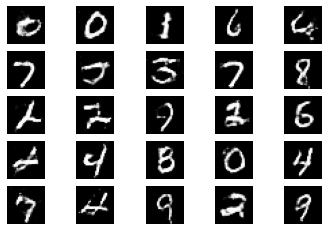

epoch:12, iter:233,  [D loss: 0.693623, acc.: 50.39%] [G loss: 0.702162]


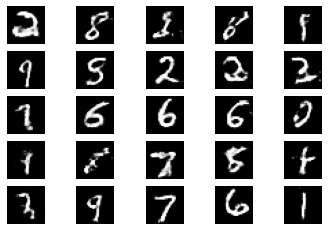

epoch:13, iter:233,  [D loss: 0.694695, acc.: 45.90%] [G loss: 0.699696]


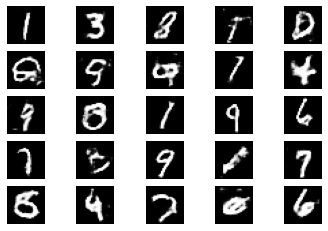

epoch:14, iter:233,  [D loss: 0.693339, acc.: 49.80%] [G loss: 0.704479]


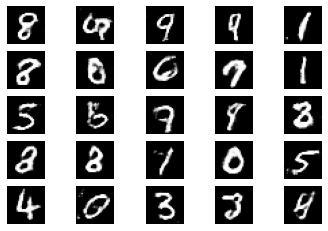

epoch:15, iter:233,  [D loss: 0.694098, acc.: 50.00%] [G loss: 0.697290]


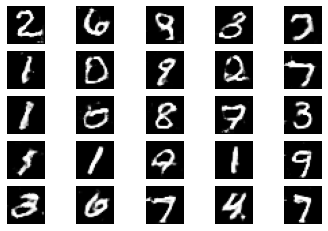

epoch:16, iter:233,  [D loss: 0.693452, acc.: 51.56%] [G loss: 0.704436]


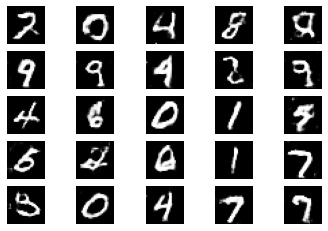

epoch:17, iter:233,  [D loss: 0.694947, acc.: 47.46%] [G loss: 0.698221]


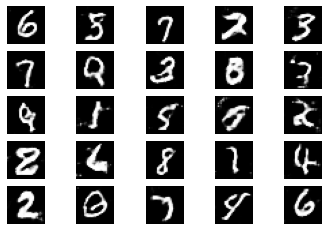

epoch:18, iter:233,  [D loss: 0.692686, acc.: 52.15%] [G loss: 0.697347]


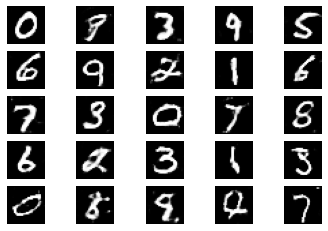

epoch:19, iter:233,  [D loss: 0.694533, acc.: 45.51%] [G loss: 0.696322]


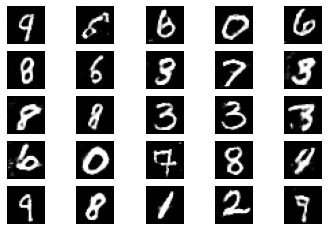

epoch:20, iter:233,  [D loss: 0.692444, acc.: 49.02%] [G loss: 0.700927]


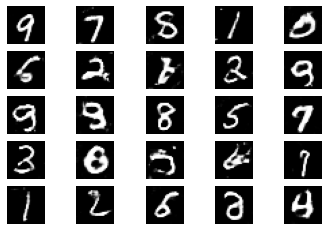

epoch:21, iter:233,  [D loss: 0.692901, acc.: 50.78%] [G loss: 0.701283]


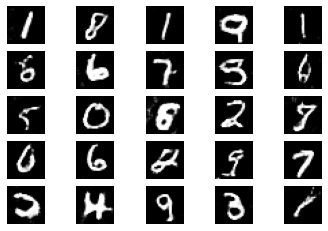

epoch:22, iter:233,  [D loss: 0.692643, acc.: 51.17%] [G loss: 0.700870]


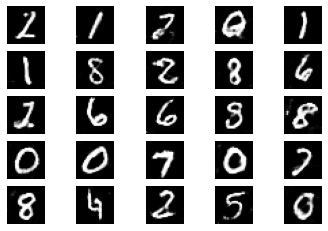

epoch:23, iter:233,  [D loss: 0.692704, acc.: 52.54%] [G loss: 0.700834]


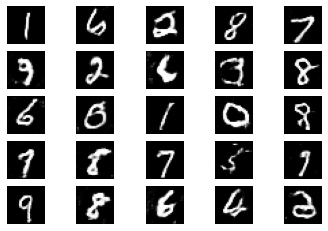

epoch:24, iter:233,  [D loss: 0.691964, acc.: 53.32%] [G loss: 0.701855]


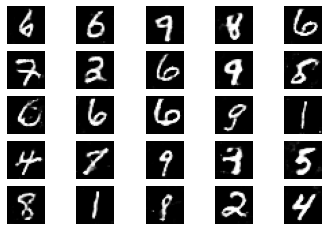

epoch:25, iter:233,  [D loss: 0.693158, acc.: 49.02%] [G loss: 0.701149]


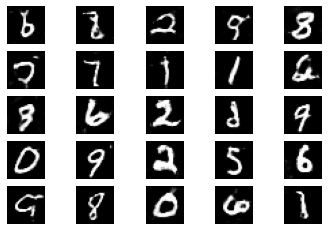

epoch:26, iter:233,  [D loss: 0.692383, acc.: 52.54%] [G loss: 0.700748]


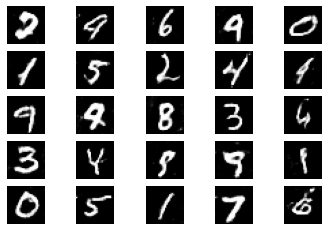

epoch:27, iter:233,  [D loss: 0.692071, acc.: 51.95%] [G loss: 0.699485]


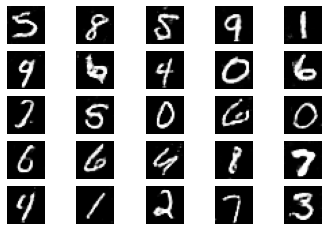

epoch:28, iter:233,  [D loss: 0.693536, acc.: 49.22%] [G loss: 0.702110]


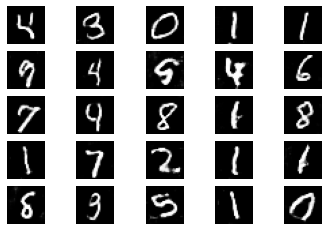

epoch:29, iter:233,  [D loss: 0.694531, acc.: 49.80%] [G loss: 0.697480]


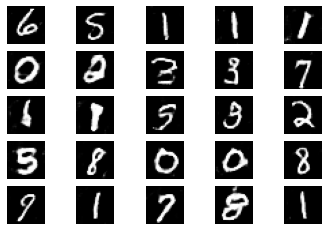

epoch:30, iter:233,  [D loss: 0.691587, acc.: 51.56%] [G loss: 0.698058]


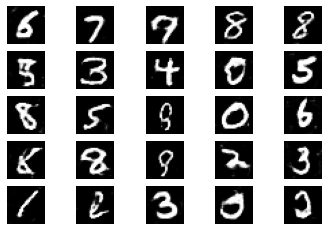

epoch:31, iter:233,  [D loss: 0.691952, acc.: 51.95%] [G loss: 0.701439]


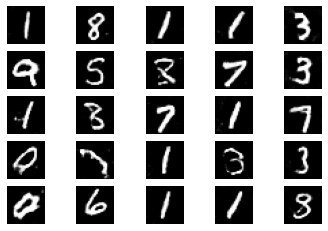

epoch:32, iter:233,  [D loss: 0.695520, acc.: 43.55%] [G loss: 0.701667]


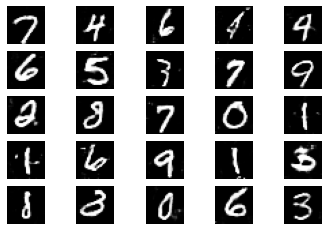

epoch:33, iter:233,  [D loss: 0.693087, acc.: 50.39%] [G loss: 0.702852]


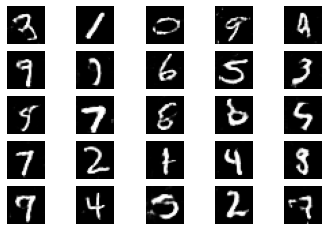

epoch:34, iter:233,  [D loss: 0.694190, acc.: 45.70%] [G loss: 0.699900]


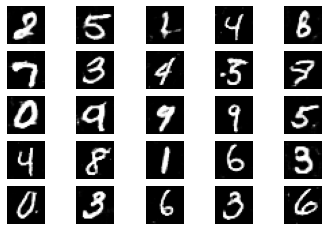

epoch:35, iter:233,  [D loss: 0.693544, acc.: 47.66%] [G loss: 0.699988]


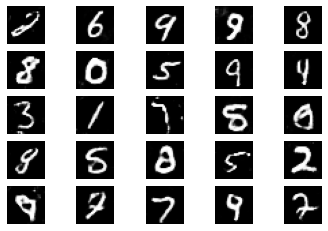

epoch:36, iter:233,  [D loss: 0.693586, acc.: 49.61%] [G loss: 0.700885]


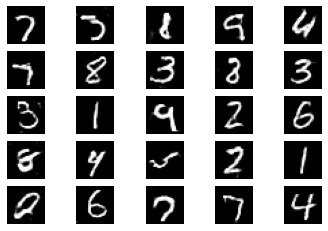

epoch:37, iter:233,  [D loss: 0.690656, acc.: 52.15%] [G loss: 0.704580]


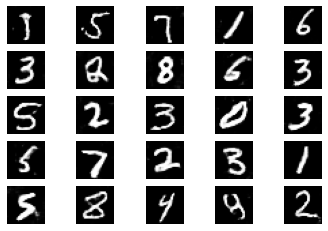

epoch:38, iter:233,  [D loss: 0.692471, acc.: 49.80%] [G loss: 0.699708]


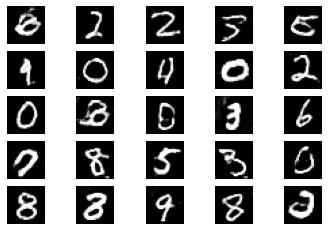

epoch:39, iter:233,  [D loss: 0.689526, acc.: 54.69%] [G loss: 0.699819]


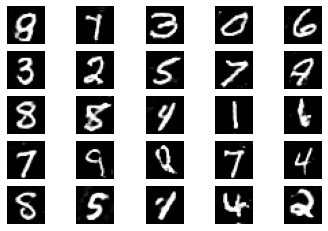

epoch:40, iter:233,  [D loss: 0.690137, acc.: 57.03%] [G loss: 0.702398]


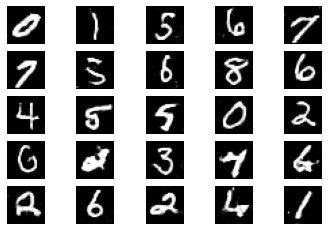

epoch:41, iter:233,  [D loss: 0.689996, acc.: 54.69%] [G loss: 0.706025]


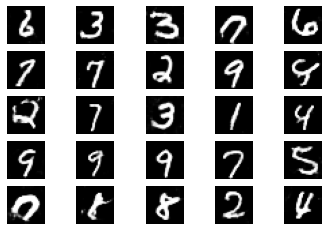

epoch:42, iter:233,  [D loss: 0.691896, acc.: 52.54%] [G loss: 0.698814]


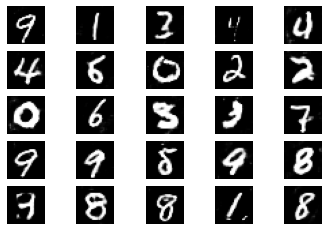

epoch:43, iter:233,  [D loss: 0.690936, acc.: 52.15%] [G loss: 0.705027]


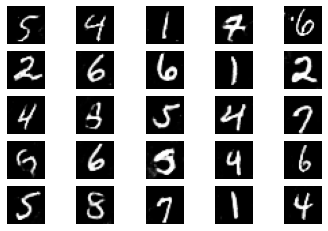

epoch:44, iter:233,  [D loss: 0.689620, acc.: 56.84%] [G loss: 0.702231]


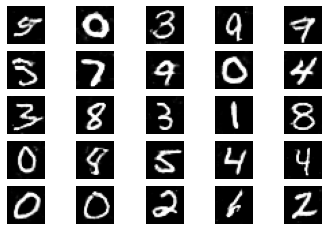

epoch:45, iter:233,  [D loss: 0.690070, acc.: 56.45%] [G loss: 0.706028]


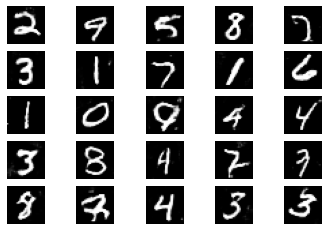

epoch:46, iter:233,  [D loss: 0.691496, acc.: 48.63%] [G loss: 0.701609]


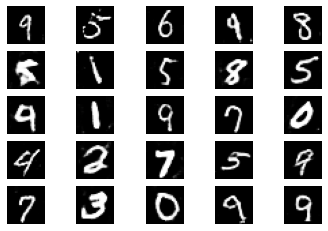

epoch:47, iter:233,  [D loss: 0.691127, acc.: 54.49%] [G loss: 0.704037]


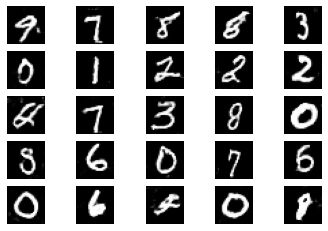

epoch:48, iter:233,  [D loss: 0.688940, acc.: 56.45%] [G loss: 0.707247]


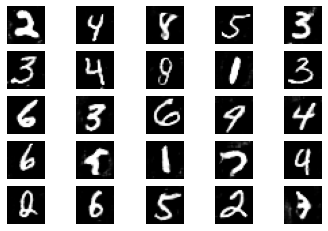

epoch:49, iter:233,  [D loss: 0.692514, acc.: 48.44%] [G loss: 0.705710]


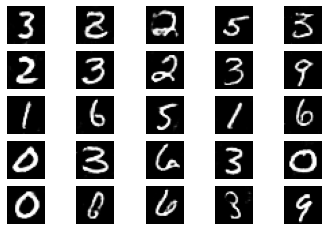

epoch:50, iter:233,  [D loss: 0.683906, acc.: 61.13%] [G loss: 0.722524]


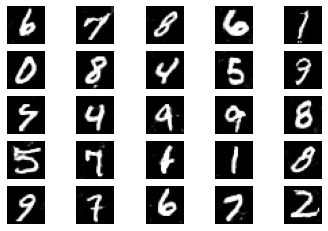

epoch:51, iter:233,  [D loss: 0.689449, acc.: 54.10%] [G loss: 0.709713]


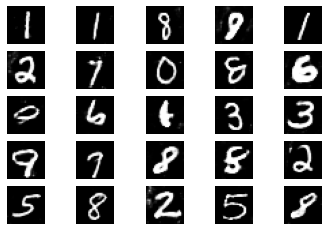

epoch:52, iter:233,  [D loss: 0.695058, acc.: 45.70%] [G loss: 0.700863]


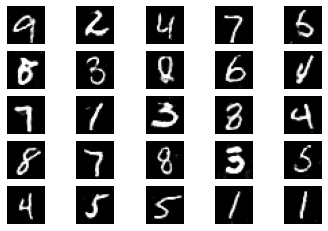

epoch:53, iter:233,  [D loss: 0.693923, acc.: 51.37%] [G loss: 0.700252]


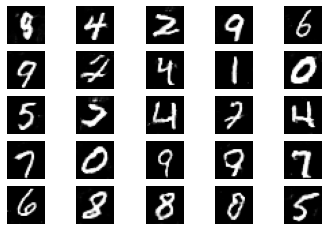

epoch:54, iter:233,  [D loss: 0.694466, acc.: 48.83%] [G loss: 0.701573]


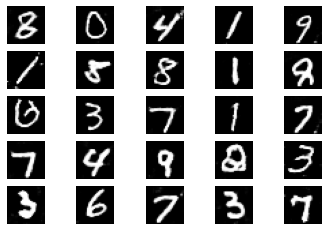

epoch:55, iter:233,  [D loss: 0.685758, acc.: 58.40%] [G loss: 0.713176]


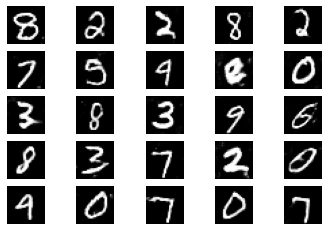

epoch:56, iter:233,  [D loss: 0.689617, acc.: 52.73%] [G loss: 0.708783]


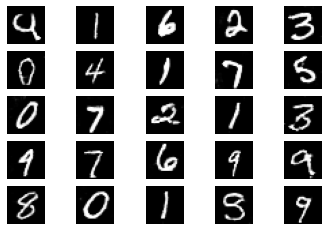

epoch:57, iter:233,  [D loss: 0.688921, acc.: 54.69%] [G loss: 0.710862]


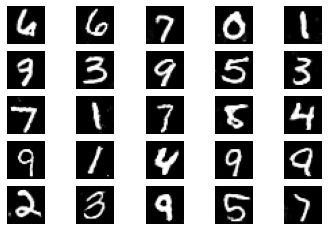

epoch:58, iter:233,  [D loss: 0.689722, acc.: 53.91%] [G loss: 0.703823]


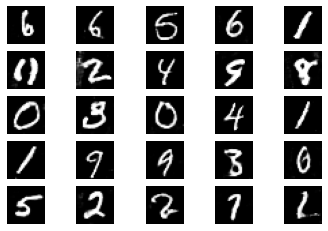

epoch:59, iter:233,  [D loss: 0.687561, acc.: 56.05%] [G loss: 0.714488]


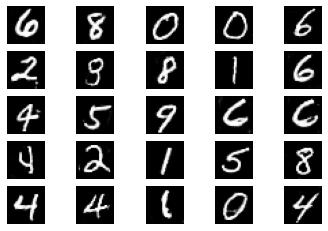

In [ ]:
#入力画像の定義
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

#潜在変数の次元数
z_dim = 20

# 最適化関数
optimizer = Adam(lr=0.0001, beta_1=0.5)

#discriminator
discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

#generator
generator = build_generator()

combined_model = build_combined()
combined_model.compile(loss="binary_crossentropy", optimizer=optimizer)

t1 = time.time() 
train(epochs=100)
t2 = time.time()

# 経過時間を表示
elapsed_time = t2 - t1
print(f"経過時間：{elapsed_time}")